**Author: Tam NGUYEN**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interp
from scipy import stats as ss

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import metrics



**1. Import data**

In [2]:
data = pd.read_csv("Churn_Modelling.csv",index_col = 0)
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**2. Check for missing data**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


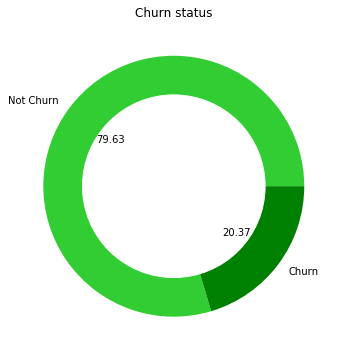

In [4]:
df = pd.DataFrame(data.groupby('Exited').Exited.count())
df.columns = ['Number of clients']
df = df.reset_index().replace(to_replace=[0,1],value=['Not Churn','Churn'])

plt.figure(figsize=(6,6))
size_of_groups = [7963, 2037]
plt.pie(size_of_groups,colors=['limegreen','green'],labels=['Not Churn','Churn'],autopct='%.2f')
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Churn status")
plt.show()



In [5]:
tenure0 = data.loc[data.Tenure==0]
print("The number of clients who have Tenure = 0 is:",tenure0.shape[0])
tenure0.head()

The number of clients who have Tenure = 0 is: 413


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
30,15656300,Lucciano,411,France,Male,29,0,59697.17,2,1,1,53483.21,0
36,15794171,Lombardo,475,France,Female,45,0,134264.04,1,1,0,27822.99,1
58,15647091,Endrizzi,725,Germany,Male,19,0,75888.20,1,0,0,45613.75,0
73,15812518,Palermo,657,Spain,Female,37,0,163607.18,1,0,1,44203.55,0
128,15782688,Piccio,625,Germany,Male,56,0,148507.24,1,1,0,46824.08,1


**Remark 1:**
- From the look of it, there is no missing data. 
- However when we look at column Tenure, there are customers who have Balance bigger than 0 and Tenure = 0 at the same time. So maybe the missing values in this dataset is encoded as 0 in case of Tenure.
- There are 413 cases like this out of 10000 clients. We could temporary ignore these observations

**3. Initial visualisation of the dataset**

**Remark 2:**

- Regardless whether IsActiveMember could improve the accuracy of the classfication or not, I would not include this in this analysis as it is a subjective record.

*3.1. For continuous variables*

In [6]:
data_clean = data.loc[data.Tenure != 0]
data_clean.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
def plot_cont(var):
    '''
    Args:
        - var(string): name of the variable
    Returns:
        - a plot
    '''
    target_df = [data_clean.loc[data_clean.Exited == target] for target in data_clean.Exited.unique()]
    fig = plt.figure(figsize=(8,5))
    colors = ['orange','green']
    for i in range(len(target_df)):
        df = target_df[i]
        sns.distplot(df.loc[:,var],hist=False,rug=True,color = str(colors[i]))
    fig.legend(labels=['Churn (Exited = 1)','Not Churn (Exited = 1)'])
    plt.title("Distribution of "+var+" by Churn status")
    plt.show()
    return(None)


C:\Users\Tybeo2301\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


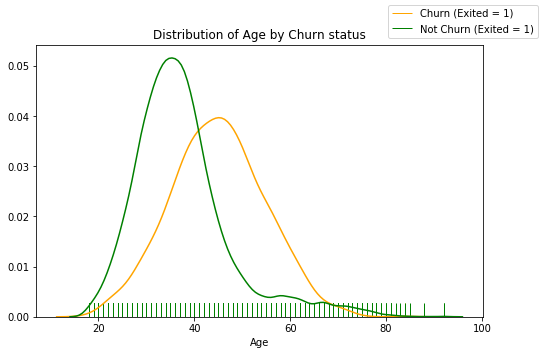

In [8]:
plot_cont('Age')

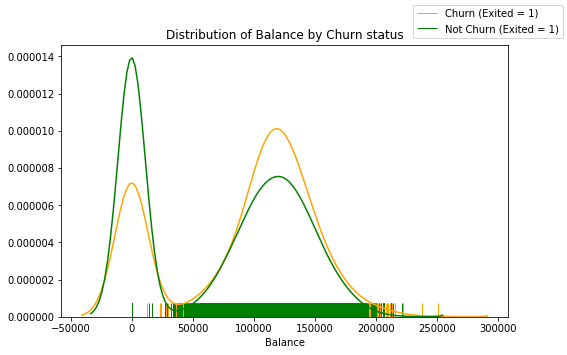

In [9]:
plot_cont('Balance')

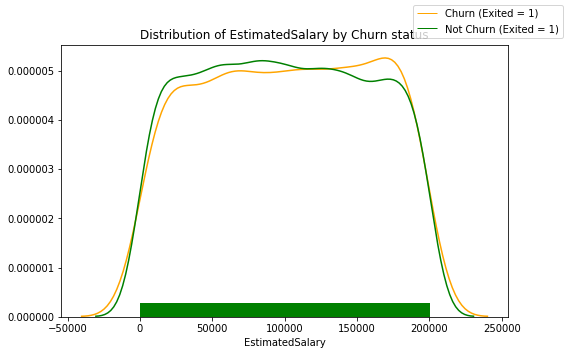

In [10]:
plot_cont('EstimatedSalary')

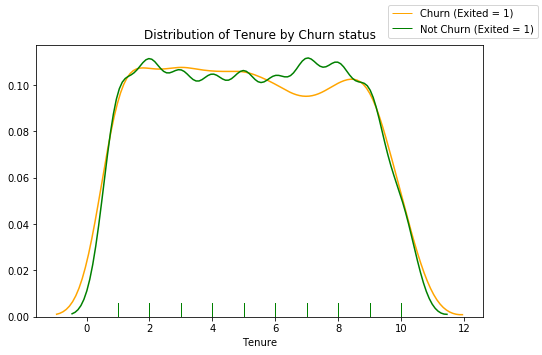

In [11]:
plot_cont("Tenure")

**Comment:**
- As there is not much difference in distribution line of Tenure or EstimatedSalary between Churn and Not-Churn group. The Tenure or Estimated Salary might have little impact on the Churn status
- The Churn group seems to have higher Balance bank amount than the counterpart. So the higher amount of balance account might stimulate the client to churn out quickly
- The older age the client get, the more inclination of churning it is.

**Remark 3:**
- Age and Balance might be signficant variables in this classfication problem

*3.2. For categorical variables*

In [12]:
def plot_cat(var):
    '''
    Args:
        - var(string): name of the variable
    Returns:
        - a plot
    '''
    plt.figure(figsize=(10,8))
    data_plot = data_clean.copy()
    data_plot["Exited"] = data_plot["Exited"].replace(to_replace=[0,1],value=['Not Churn','Churn'])
    data_plot.groupby(var,as_index=True).Exited.value_counts().unstack().transpose().plot(kind="bar",
                                title="Distribution of "+var+" by Churn status",
                                color = ['limegreen','green','palegreen','springgreen'])
    plt.show()
    return(None)

<Figure size 720x576 with 0 Axes>

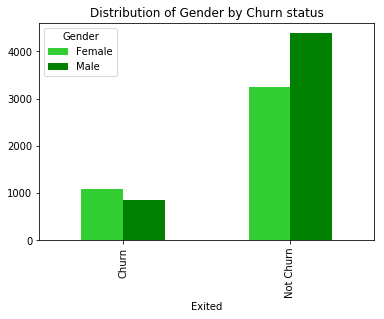

In [13]:
plot_cat('Gender')

<Figure size 720x576 with 0 Axes>

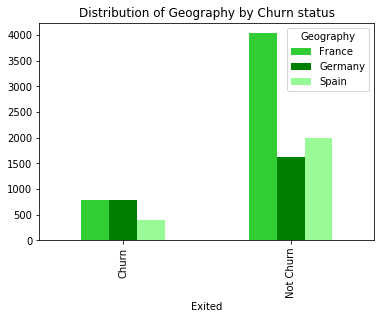

In [14]:
plot_cat('Geography')

<Figure size 720x576 with 0 Axes>

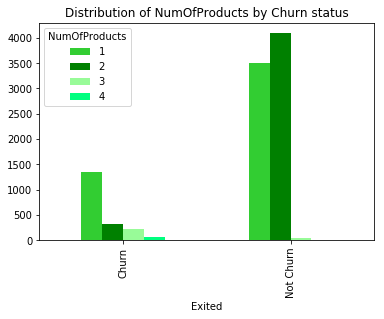

In [15]:
plot_cat('NumOfProducts')

<Figure size 720x576 with 0 Axes>

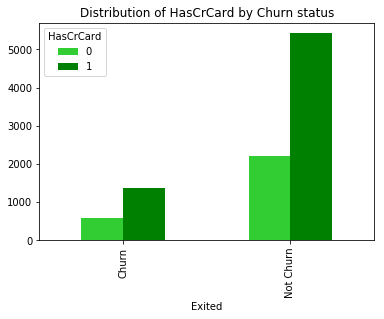

In [16]:
plot_cat('HasCrCard')

**Comment:**
- There are more female than male clients in the Churn group while we observe the reserve trend in the Non-Churn Group
- A fairly balance number of clients from Spain, Germany and France is recorded in Churn group while in Non-Churn Group, a clear distinction between France and other countries is observed. So clients not from France might be inclined more to churn out
- Client uses one two products tend to stay back. Clients that use more than that might have more motivation to exit
- There is not much difference between HasCrCard distribution in both Group

**Remark 4:**
- Gender, Geography and NumOfProducts might effect the churn decision of client

**4. Correlation identification**

Target variables: 
- Continuous vars: Age, Balance, EstimatedSalary, Tenure
- Categorical vars: Tenure, Gender, Geography, NumOfProducts, HasCrCard

In [17]:
#Between categorical variables:
def cramers_v(var1, var2):
    '''
    Args:
        - var1 and var2 are categorical variables
    Returns:
        - Cramers_v statistics
    Source: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    '''
    #var1 = pd.factorize(var1)
    #var2 = pd.factorize(var2)
    confusion_matrix = pd.crosstab(data_clean[var1],data_clean[var2])
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    stat = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    return(round(stat,3)) 

In [18]:
cat = ["Gender", "Geography", "NumOfProducts", "HasCrCard"]
Variable1 = []
Variable2 = []
Corr = []
for var1 in cat:
    for var2 in cat:
        val = cramers_v(var1, var2)
        Variable1.append(var1)
        Variable2.append(var2)
        Corr.append(val)

In [19]:
#Between continuous variables
cont = ["CreditScore","Age", "Balance", "EstimatedSalary", "Tenure"]
for var1 in cont:
    for var2 in cont:
        val = ss.pearsonr(data_clean[var1], data_clean[var2])[0]
        Variable1.append(var1)
        Variable2.append(var2)
        Corr.append(val)

In [20]:
#Between continous and categorical variables
def correlation_ratio(var_cat, var_num):
    '''
    Args:
        - var_cat: categorical variable
        - var_num: numerical variable
    Returns:
        - Correlation ratio
    Source: https://en.wikipedia.org/wiki/Correlation_ratio
    '''   
    cat_num = len(data_clean[var_cat].unique())
    
    y_avg_array = []
    n_array = []
    
    for i in data_clean[var_cat].unique():
        array = data_clean.loc[data_clean[var_cat]==i,var_num]
        n_array.append(len(array))
        y_avg_array.append(array.mean())
    
    y_avg_total = (sum(np.multiply(y_avg_array,n_array)))/sum(n_array)
    
    num = sum(np.multiply(n_array,(y_avg_array - y_avg_total)**2))
    denum = sum((data[var_num] - y_avg_total)**2)
    
    eta = np.sqrt(num/denum)
    return(eta)

In [21]:
for var1 in cat:
    for var2 in cont:
        val = correlation_ratio(var1, var2)
        Variable1.extend([var1,var2])
        Variable2.extend([var2,var1])
        Corr.extend([val,val])

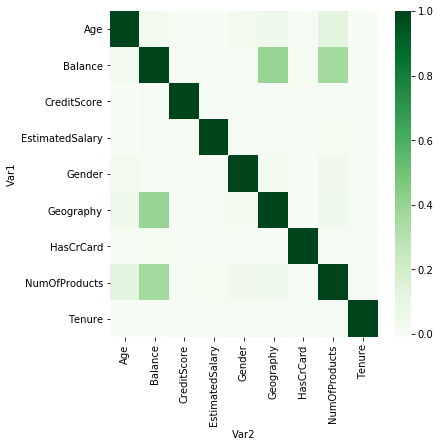

In [22]:
#Summary
corr_dict = {'Var1':Variable1,'Var2':Variable2,"Correlation":Corr}
corr_df = pd.DataFrame.from_dict(corr_dict)
corr_df = pd.pivot_table(corr_df,index='Var1',columns='Var2',values='Correlation')
plt.figure(figsize=(6,6))
sns.heatmap(corr_df, 
            xticklabels=corr_df.columns.values,
            yticklabels=corr_df.columns.values,cmap="Greens")

**Remark 5:** 
- No significant correlation is detected

**5. Discritize some continuous variables and Find the most important variables**

In [23]:
#Discritize continuos variables
data_clean.loc[:,'Age'] = pd.qcut(data_clean['Age'],q=[0, .25, .5, .75, 1.])
data_clean.loc[:,'Tenure'] = pd.qcut(data_clean['Tenure'],q=[0, .25, .5, .75, 1.])

C:\Users\Tybeo2301\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Tybeo2301\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
#Find the most important variables: We only care for categorical variables as there are only two continuous variables
#For categorical variables:
chi2 = []
var = []
pval = []
for var1 in ['Gender', 'Geography', 'NumOfProducts', 'HasCrCard','Age','Tenure']:
    confusion_matrix = pd.crosstab(data_clean[var1],data_clean['Exited'])
    stat = ss.chi2_contingency(confusion_matrix)
    chi2.append(round(stat[0],4))
    pval.append(round(stat[1],4))
    var.append(var1)
chiq2_df = pd.DataFrame.from_dict({"Variable":var,"Chi_sq":chi2,"Pvalue":pval})
chiq2_df = chiq2_df.sort_values(by='Chi_sq',ascending=False)
chiq2_df.head(10)

,Variable,Chi_sq,Pvalue
2,NumOfProducts,1475.1852,0.0000
4,Age,1216.6040,0.0000
1,Geography,291.1843,0.0000
0,Gender,109.0701,0.0000
5,Tenure,5.4831,0.1397
3,HasCrCard,0.6400,0.4237


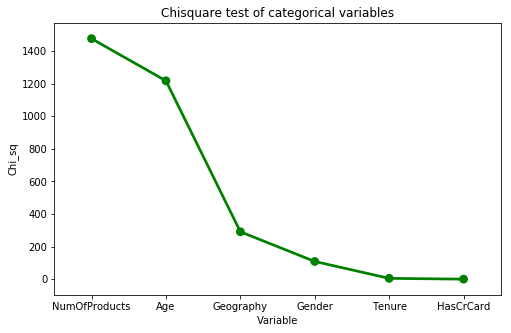

In [25]:
plt.figure(figsize=(8,5))
sns.pointplot(x='Variable',y='Chi_sq',data=chiq2_df,join=True,color='green')
plt.title("Chisquare test of categorical variables")
plt.show()

**Remark 6:**
- p_value of Tenure and HasCrCard bigger than 0.05 so we could not reject the hypothesis that Tenure or HasCrCard is independent from Churn status. This is in line with the initial visualisation in section 3. **So we would not include these variable in the model**
- Regarding categorical variables, "Age" and "Number of products" have highest chisquare value which indicates the most important variables to this classification problem

**6. Model Performance and Selection**

We would apply both the Logistic Regression and Random Forest Cross Validation in this case to avoid overfitting

In [26]:
data_model = data_clean.replace(to_replace=["Female","Male"],value=[0,1])
data_model = pd.get_dummies(data_model, columns=['Geography', 'Age','NumOfProducts'], drop_first=True)
data_model = data_model.drop(["CustomerId","Surname","Tenure","HasCrCard","IsActiveMember"],axis=1)

In [27]:
def cv_prediction(dataset,algo,cv_fold=10):
    '''
    Args:
        - dataset(Pandas DataFrame): data
        - algo(string): either "Logistics" or "RF"
        - cv_fold(int): number of folds for cross validation
    Returns:
        - res: prediction:
        - tprs,base_fpr,aucs: metrics to construct ROC
    ''' 
    res = pd.DataFrame(columns=['Actual','Pred'])
    
    kf = KFold(n_splits=cv_fold, shuffle=True)
    folds = [test_ind for (train_ind, test_ind) in kf.split(dataset)]
    
    if algo == "Logistics":
        model = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr')
    elif algo == "RF":
        model = RandomForestClassifier(n_estimators=100)
    
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    
    for i in range(len(folds)):
        train = dataset[dataset.index.isin(folds[i])==False]
        test = dataset[dataset.index.isin(folds[i])==True]
        
        x_train = train.drop(['Exited'],axis = 1).reset_index(drop=True)
        x_test = test.drop(['Exited'],axis = 1).reset_index(drop=True)
        y_train = train.Exited.reset_index(drop=True)
        y_test = test.Exited.reset_index(drop=True)
    
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        
        #For ROC Curve:
        y_score  = model.predict_proba(x_test)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_score[:, 1])
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

        #For metrics evaluation
        pred = pd.DataFrame([y_test,y_pred]).transpose()
        pred.columns = ['Actual','Pred']
        res = pd.concat([res,pred],axis=0) 
    return(res, tprs,base_fpr,aucs)


def metrics_eva(data_prediction):
    '''
    Args:
        - data_prediction(Pandas DataFrame): prediction
    Returns:
        - res_acc: metrics performance
    '''
    actual = data_prediction.Actual.tolist()
    pred = data_prediction.Pred.tolist()
    res_acc = pd.Series({ 
            'Precision_score': [metrics.precision_score(actual, pred)],
            'Recall_score': [metrics.recall_score(actual, pred)],
            'F1_score': [metrics.f1_score(actual, pred,labels=np.unique(pred))],
            'Accuracy': [metrics.accuracy_score(actual, pred)]})
    
    return(res_acc)

def roc_curve(tprs, base_fpr, aucs, label):
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    
    mean_auc = metrics.auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    plt.plot(base_fpr, mean_tprs, 'b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8,color='green')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.axes().set_aspect('equal', 'datalim')
    plt.title('Receiver operating characteristic (ROC) of '+label)
    plt.legend(loc="lower right")
    plt.show()
    return(None)

C:\Users\Tybeo2301\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tybeo2301\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tybeo2301\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


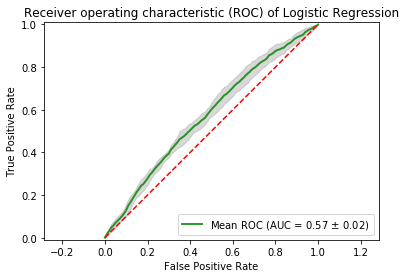

In [28]:
#Logistic regression:
res_logistic, tprs_logistic, base_fpr_logistic,aucs_logistic = cv_prediction(data_model,algo="Logistics",cv_fold=10)
acc_logistic = metrics_eva(res_logistic)
roc_curve(tprs_logistic, base_fpr_logistic, aucs_logistic, label = "Logistic Regression")

C:\Users\Tybeo2301\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


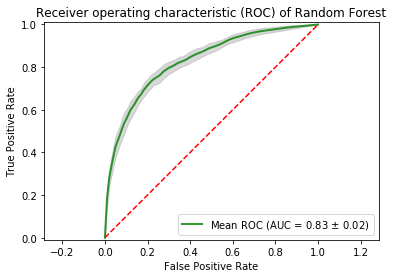

In [29]:
#Random Forest:
res_rf, tprs_rf, base_fpr_rf, aucs_rf = cv_prediction(data_model,algo="RF",cv_fold=10)
acc_rf = metrics_eva(res_rf)
roc_curve(tprs_rf, base_fpr_rf, aucs_rf, label = "Random Forest")

**Remark 7:** 
- Random Forest is a better model than Logistic Regression in this case
- Model Improvement (Please see the file attached to this file)